In [48]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [49]:
!kaggle datasets download -d arjuntejaswi/plant-village

plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [50]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plant-village.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [51]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [52]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [73]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    'Datasets',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [74]:
classes_names = datasets.class_names
classes_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [75]:
type(datasets)

tensorflow.python.data.ops.batch_op._BatchDataset

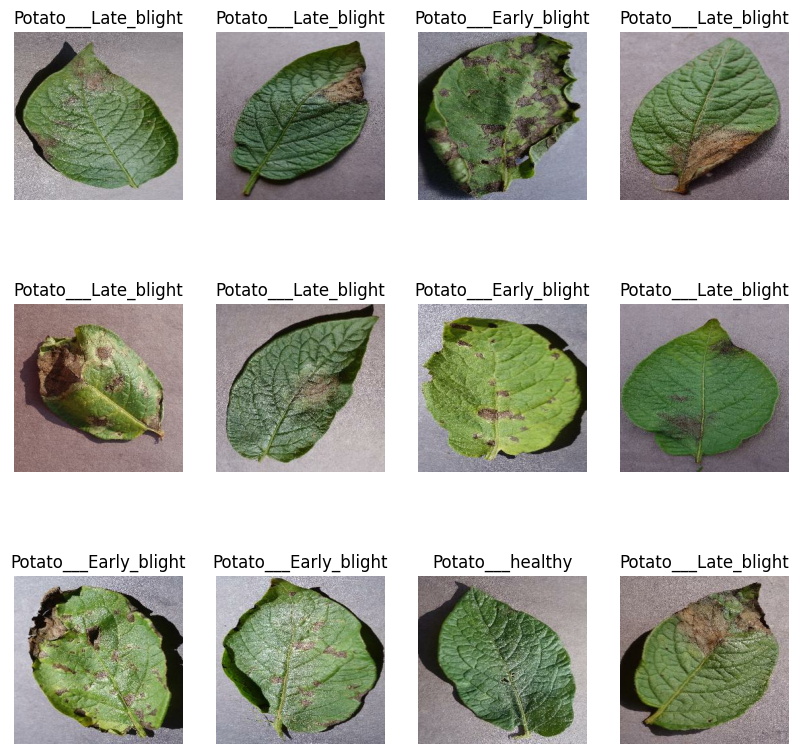

In [76]:
plt.figure(figsize = (10, 10))
for batch, label in datasets.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(batch[i].numpy().astype('uint8'))
    plt.title(classes_names[label[i]])
    plt.axis('off')

In [77]:
len(datasets) * BATCH_SIZE

2176

In [78]:
len(datasets) * 0.8

54.400000000000006

In [79]:
train_ds = datasets.take(55)
test_ds = datasets.skip(55)

In [80]:
len(train_ds)

55

In [81]:
len(test_ds)

13

In [82]:
val_ds = test_ds.take(5)

In [83]:
test_ds = test_ds.skip(5)

In [84]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).keep(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [85]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [86]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [87]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [88]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(3, activation = 'sigmoid')
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

In [89]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [90]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [91]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
55/55 [==============================] - 12s 111ms/step - loss: 0.9127 - accuracy: 0.4824 - val_loss: 0.7905 - val_accuracy: 0.6125
Epoch 2/50
55/55 [==============================] - 3s 61ms/step - loss: 0.6131 - accuracy: 0.7165 - val_loss: 0.4775 - val_accuracy: 0.7875
Epoch 3/50
55/55 [==============================] - 3s 61ms/step - loss: 0.4113 - accuracy: 0.8295 - val_loss: 0.6517 - val_accuracy: 0.7375
Epoch 4/50
55/55 [==============================] - 3s 61ms/step - loss: 0.3479 - accuracy: 0.8608 - val_loss: 0.5125 - val_accuracy: 0.8313
Epoch 5/50
55/55 [==============================] - 3s 63ms/step - loss: 0.3054 - accuracy: 0.8875 - val_loss: 0.3731 - val_accuracy: 0.8438
Epoch 6/50
55/55 [==============================] - 3s 61ms/step - loss: 0.2605 - accuracy: 0.8920 - val_loss: 0.2552 - val_accuracy: 0.9062
Epoch 7/50
55/55 [==============================] - 3s 61ms/step - loss: 0.2456 - accuracy: 0.9034 - val_loss: 0.2803 - val_accuracy: 0.8687
Epoch 8/50


In [92]:
model.evaluate(test_ds)

8/8 [==============================] - 3s 28ms/step - loss: 0.0364 - accuracy: 0.9914


[0.036385081708431244, 0.9913793206214905]

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch

Text(0.5, 1.0, 'Training vs Test Accuracy')

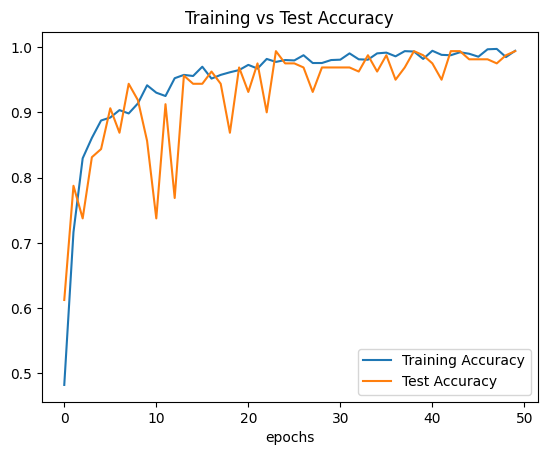

In [96]:
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Test Accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.title("Training vs Test Accuracy")

Text(0.5, 1.0, 'Training vs Test Loss')

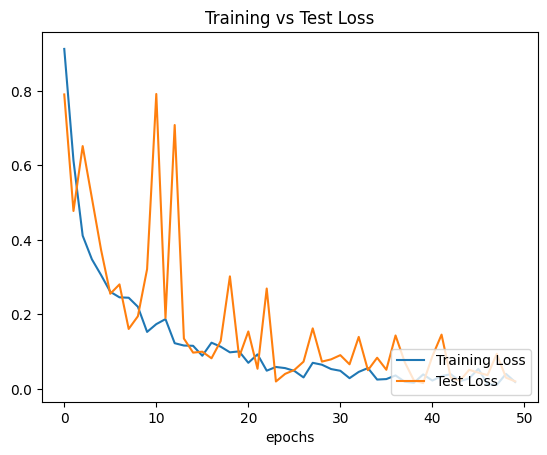

In [97]:
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Test Loss')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.title("Training vs Test Loss")

In [103]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
model.save("E:\DeepLearning\PotatoPlantDiseaseDetection\model\1.h5")

In [105]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [108]:
!ls /content/gdrive/MyDrive

'Colab Notebooks'


In [109]:
import torch
model_save_name = 'model.pt'
path = f"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

AttributeError: ignored

In [110]:
model.save(path)